In [1]:
from PIL import Image, ImageDraw
import sys
# define acllite library path
sys.path.append('../../Common/acllite')
# modules of acllite library
from acllite_model import AclLiteModel
from acllite_resource import AclLiteResource
from acllite_imageproc import AclLiteImageProc
from acllite_image import AclLiteImage
from src.model import preprocessing, postprocessing, construct_image_info

In [2]:
# define device id & model path
device_id = 0
model_path = "./model/yolov3_caffe.om"

# define image & coco_names path
img_path = "../../Common/data/dog.jpg"
coco_names_path  = "../../Common/data/coco.names"

In [3]:
with open(coco_names_path) as fd:
    coco_labels = fd.readlines()

coco_labels = [i[:-1] for i in coco_labels][0:]

In [4]:
# initialize acllite library
acl_resource = AclLiteResource()
acl_resource.init()

# load *.om model
model = AclLiteModel(model_path, device_id)

# initialize dvpp
dvpp = AclLiteImageProc(acl_resource)

# get acllite image
image = AclLiteImage(img_path)

init resource stage:
Init resource success
Init model resource start...
[AclLiteModel] create model output dataset:
malloc output 0, size 24576
malloc output 1, size 32
Create model output dataset success
Init model resource success


In [5]:
# 1) pre-processing stage
resized_image = preprocessing(image, dvpp, model._model_desc)

input  0
model input dims ({'name': 'data', 'dimCount': 4, 'dims': [1, 416, 416, 3]}, 0)
model input datatype 4
input  1
model input dims ({'name': 'img_info', 'dimCount': 2, 'dims': [1, 4]}, 0)
model input datatype 0
model output size 2
output  0
model output dims ({'name': 'detection_out3:0:box_out', 'dimCount': 2, 'dims': [1, 6144]}, 0)
model output datatype 0
output  1
model output dims ({'name': 'detection_out3:1:box_out_num', 'dimCount': 2, 'dims': [1, 8]}, 0)
model output datatype 3
[Image] Image decoded.
[AclLiteImageProc] vpc crop and paste stage:
[AclLiteImageProc] vpc crop and paste stage success
[Image] YUV image resized.


In [6]:
# 2) model execution(forward) stage
result_list = model.execute([resized_image, construct_image_info(model._model_desc)]) 

In [7]:
# 3) post-processing the raw predictions
bboxes = postprocessing(result_list,image ,model._model_desc)

In [8]:
img_out = Image.open(img_path)
img1 = ImageDraw.Draw(img_out)

for idx,bbox in enumerate(bboxes):
    img1.rectangle(list(bbox[0:4]), outline =(255,0,0), width=2)
    print(bbox[0:4], bbox[4], int(bbox[5]), coco_labels[int(bbox[5])])   
    img1.rectangle((bbox[0], bbox[1] -15, bbox[0] + len(coco_labels[int(bbox[5])])*8, bbox[1]), 
                outline = (255,255,255), width=10) 
    img1.text((bbox[0]+5, bbox[1]-15), coco_labels[int(bbox[5])], (255,0,0), thickness=40)

[183.0, 114.75, 560.3076923076924, 429.69230769230774] 0.9921875 1 bicycle
[472.61538461538464, 84.0, 688.6153846153846, 165.34615384615387] 0.81640625 7 truck
[128.30769230769232, 210.0, 312.92307692307696, 536.7692307692308] 0.9931640625 16 dog


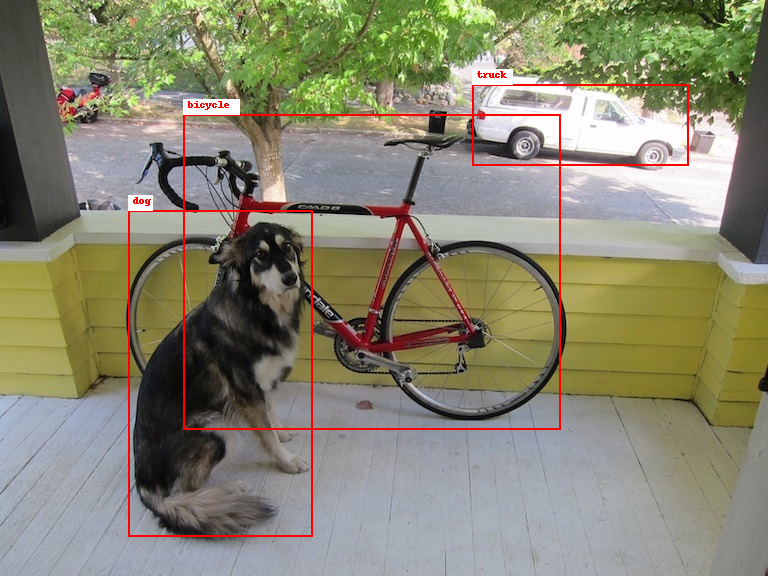

In [9]:
img_out